## Importing Torch and checking if cuda is available or not

In [13]:
import torch
print(torch.cuda.is_available())

True


## Installing required libraries

In [14]:
! pip install pytorch-lightning
! pip install lightning-bolts

## Importing Packages

In [15]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F

from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
import random
import cv2
import os
import matplotlib.pyplot as plt

In [16]:
from torchvision import datasets

class Cifar10SearchDataset(torchvision.datasets.CIFAR10):

    def __init__(self, root="./data", train=True, download=True, transform=None):
      super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
      image, label = self.data[index], self.targets[index]

      if self.transform is not None:
        transformed = self.transform(image=image)
        image = transformed["image"]

        return image, label

## Augumentation Techniques

In [17]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

mu_cifar = (0.49139968, 0.48215827, 0.44653124)
sigma_cifar = (0.24703233, 0.24348505, 0.26158768)

def augmentation(data, mu=mu_cifar, sigma=sigma_cifar, pad=4):
    if data == 'Train':
        transform = A.Compose([A.HorizontalFlip(p=0.5),
                            A.Normalize(mean=mu, std=sigma),
                            ToTensorV2()])
    elif data == 'Test':
        transform = A.Compose([A.Normalize(mean=mu_cifar, std=sigma_cifar),
                           ToTensorV2()])
    else:
        transform = A.Compose([ToTensorV2()])

    return transform

In [18]:
def num_to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

def categorical_to_num(y):
  """ Decodes a 1-hot encoding """
  return np.argmax(y)

In [19]:
# Dataset is there to be able to interact with DataLoader
from torch.utils.data import Dataset

class cifar10_data(Dataset):
  '''
  cifar10_data class to create an iteratable on our custom cifar10 dataset:
  where data = (image and image label as one-hot-encoding) and labels = (image)
  '''

  def __init__(self, d):
    self.cifar = d                                                              

  def __getitem__(self, index):

    image, label = self.cifar[index]
    number_encoding = num_to_categorical(label, 10)                             
    number_encoding = torch.tensor(number_encoding)

    return image, number_encoding                                               

  def __len__(self):                                                            
    return len(self.cifar)

In [20]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes_dict = {c:idx for idx, c in enumerate(classes)}

## Defining the model

In [21]:
BATCH_SIZE = 512

class VAE(pl.LightningModule):
    def __init__(self, data_dir, n_labels=10, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.data_dir = data_dir
        self.transform_train = augmentation('Train')
        self.transform_valid = augmentation('Test')
        self.n_labels = n_labels
        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim+self.n_labels, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim+self.n_labels, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, label = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)

        mu, log_var = self.fc_mu(torch.cat((x_encoded, label), dim=1)), self.fc_var(torch.cat((x_encoded, label), dim=1))

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

    def prepare_data(self):
        # download
        Cifar10SearchDataset(self.data_dir, train=True, download=True, transform=None)
        Cifar10SearchDataset(self.data_dir, train=False, download=True, transform=None)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            self.cifar_train = cifar10_data(Cifar10SearchDataset(self.data_dir, train=True, download=False, transform=self.transform_train))
            self.cifar_valid = cifar10_data(Cifar10SearchDataset(self.data_dir, train=False, download=False, transform=self.transform_valid))

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.cifar_test = cifar10_data(Cifar10SearchDataset(self.data_dir, train=False, download=False, transform=self.transform_valid))

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

    def val_dataloader(self):
        return DataLoader(self.cifar_valid, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

In [22]:
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelSummary

## Running the model

In [ ]:
epochs = 30
num_classes=10
learning_rate=1e-4

model = VAE('.')
trainer = Trainer(
    callbacks=[ModelSummary(max_depth=-1)],
    accelerator='gpu',
    devices=1,
    max_epochs = epochs
    )
trainer.fit(model)

<ipython-input-9-1e4818c0a58f>:14: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/autoencoders/components.py:236: UnderRe

100%|██████████| 170498071/170498071 [00:14<00:00, 12109092.28it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
    | Name                          | Type              | Params
----------------------------------------------------------------------
0   | encoder                       | ResNetEncoder     | 11.2 M
1   | encoder.conv1                 | Conv2d            | 1.7 K 
2   | encoder.bn1                   | BatchNorm2d       | 128   
3   | encoder.relu                  | ReLU              | 0     
4   | encoder.maxpool               | MaxPool2d         | 0     
5   | encoder.layer1                | Sequential        | 147 K 
6   | encoder.layer1.0              | EncoderBlock      | 74.0 K
7   | encoder.layer1.0.conv1        | Conv2d            | 36.9 K
8   | encoder.layer1.0.bn1          | BatchNorm2d       | 128   
9   | encoder.layer1.0.relu         | ReLU              | 0     
10  | encoder.layer1.0.conv2        | Conv2d            | 36.9 K
11  | encoder.laye

Training: 0it [00:00, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


## Saving the model

In [ ]:
torch.save(model.state_dict(), 'CIFAR10_pl.pth')

## Loading the model

In [23]:
model = VAE('.')

<ipython-input-21-1e4818c0a58f>:14: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
<ipython-input-21-1e4818c0a58f>:15: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(


In [24]:
model.load_state_dict(torch.load("CIFAR10_pl.pth", weights_only=True))

<All keys matched successfully>

In [25]:
test_set = Cifar10SearchDataset(train=False, download=True, transform=augmentation('Test'))
test_set_custom = cifar10_data(test_set)

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

test_loader = torch.utils.data.DataLoader(
    test_set_custom,
    batch_size = BATCH_SIZE,
    shuffle=True,
    **kwargs
)

100%|██████████| 170498071/170498071 [00:08<00:00, 20513998.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## Doing Predictions

In [26]:
def model_call(model, input1, input2):

    with torch.no_grad():

        encoded_image = model.encoder(input1)
        linear_layer = torch.cat((encoded_image, input2), dim=1)
        mu, log_var = model.fc_mu(linear_layer), model.fc_var(linear_layer)

        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        decoded_image = model.decoder(z).to('cpu')

        return decoded_image

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
count = 0
all_predictions_wrong = []
all_predictions_correct = []
all_labels = []

for data, label in test_loader:

    r_idx = random.randrange(0, 256)

    input = data[r_idx]
    gt = label[r_idx]

    correct_label = categorical_to_num(np.array(gt))

    while count < 25:
        r_label = random.randrange(0, 10)
        if r_label != correct_label:
            wrong_label = r_label

            all_labels.append([correct_label, wrong_label])

            wrong_label_vector = num_to_categorical(wrong_label, 10)
            gt_mod = gt.clone()
            gt_mod = torch.tensor(wrong_label_vector)

            ## unqueeze to get batch dim
            input1 = input.unsqueeze(0)
            input2 = gt.unsqueeze(0)
            input2_mod = gt_mod.unsqueeze(0)

            # print(f'gt label {correct_label}, wrong label added {wrong_label}')

            prediction_correct = model_call(model.to(device), input1.to(device), input2.to(device)).detach().cpu().squeeze(0).squeeze(0)
            prediction_wrong = model_call(model.to(device), input1.to(device), input2_mod.to(device)).detach().cpu().squeeze(0).squeeze(0)

            all_predictions_correct.append(prediction_correct)
            all_predictions_wrong.append(prediction_wrong)

            count += 1

    break

In [32]:
id2classes = {classes_dict[key]:key for key in classes_dict.keys()}

In [33]:
id2classes

{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [34]:
mu_cifar = (0.49139968, 0.48215827, 0.44653124)
sigma_cifar = (0.24703233, 0.24348505, 0.26158768)

In [35]:
def plot_grid(image, labels, noise=False):

    nrows = 5
    ncols = 5

    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 10))

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            ax[i, j].axis("off")
            img = torch.tensor(image[index]).permute(1, 2, 0).numpy()*sigma_cifar + mu_cifar

            ax[i, j].imshow(img)

            correct, wrong = labels[index]
            if noise:
                s = f'True: {id2classes[correct]}\nNoise: {id2classes[wrong]}'
                ax[i, j].text(0, 5, s, color='Black')
            else:
                s = f'True: {id2classes[correct]}'
                ax[i, j].text(0, 2, s, color='Black')

    plt.subplots_adjust(wspace=0, hspace=0.01)

<ipython-input-35-6a8badb95c4a>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image[index]).permute(1, 2, 0).numpy()*sigma_cifar + mu_cifar


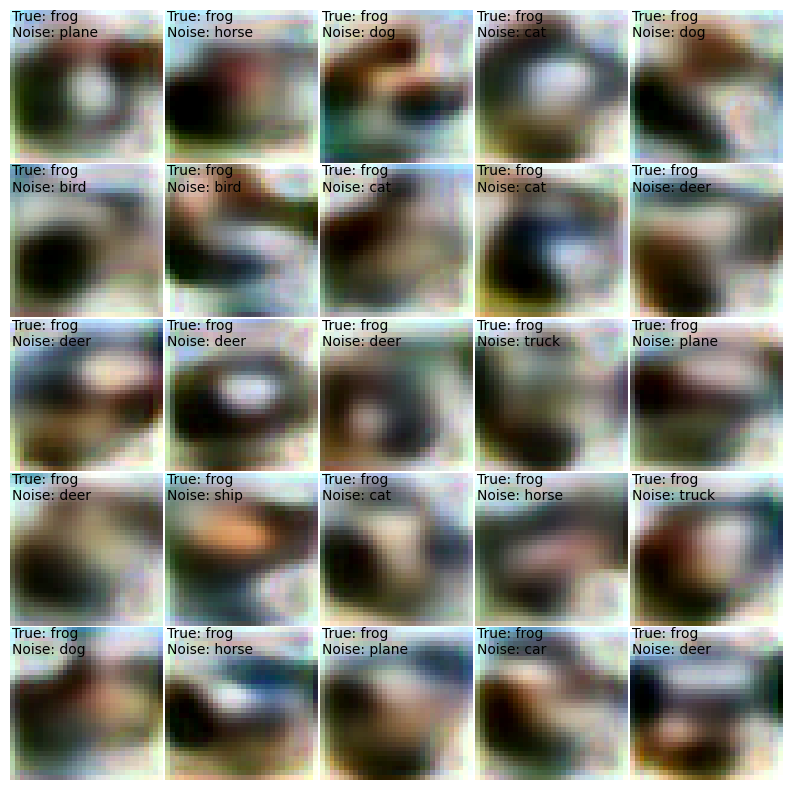

In [36]:
plot_grid(all_predictions_wrong, all_labels, True)